In [1]:
%load_ext autoreload
%autoreload 2

# Experiments on Toy Data

In [2]:
from aggregation import experiment
import numpy as np

mses, cates = experiment(6, n=500, random_state=1, train_on_val=True, cfit_on_val=True)

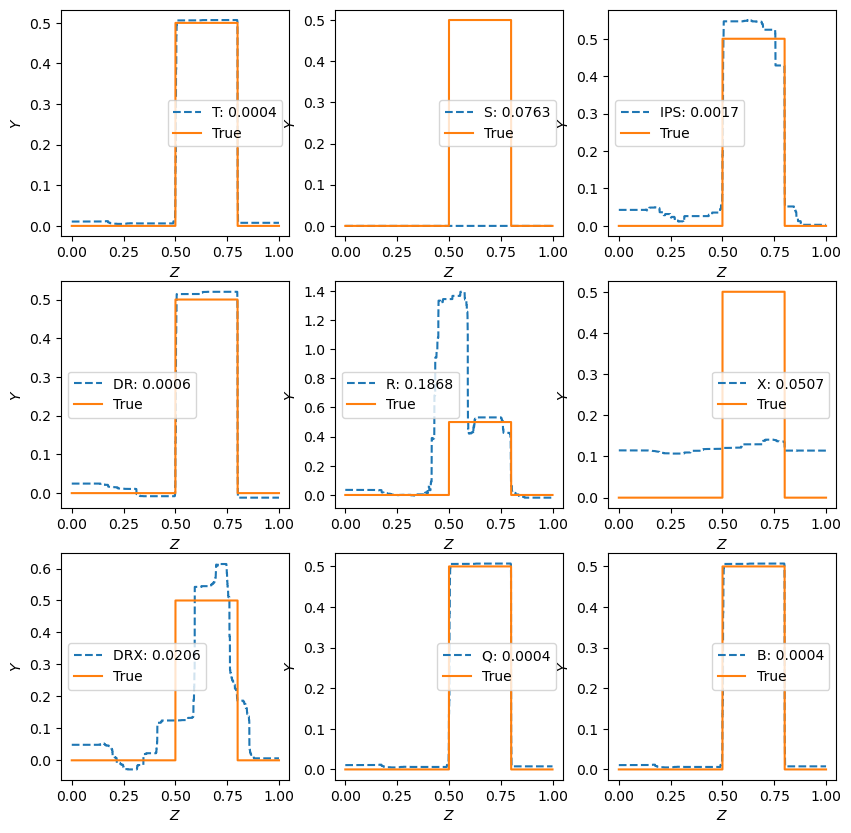

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(3, 3, it + 1)
    plt.plot(cates['Ztest'], cates[name], '--', label=f'{name}: {mse:.4f}')
    plt.plot(cates['Ztest'], cates['True'], '-', label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.show()

In [ ]:
from aggregation import experiment
import numpy as np
from joblib import Parallel, delayed 

all_results = {}
for dgp in np.arange(1, 7):
    all_results[dgp] = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(dgp, n=500,
                                                                          # whether nuisances in drscore
                                                                          # are fitted on the validation set
                                                                          # or we use the ones fitted on the
                                                                          # training set
                                                                          train_on_val=False,
                                                                          # whether we do crossfitting for
                                                                          # the nuisances in the drscore.
                                                                          cfit_on_val=True,
                                                                          random_state=it)
                                                      for it in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for dgp in np.arange(1, 7):
    results = all_results[dgp]
    mses, _ = results[0]
    names = list(mses.keys())
    rmses_agg = {}
    rmses_all = {}
    for name in names:
        mses = [r[0][name] for r in results]
        rmses_all[name] = np.sqrt(np.array(mses))
        rmses_agg[name] = (np.mean(rmses), np.std(rmses), np.std(rmses) / np.sqrt(len(results)))

    min_rmse, _, _ = np.min(pd.DataFrame(rmses_agg), axis=1)
    min_ind, _, _ = np.argmin(pd.DataFrame(rmses_agg).values, axis=1)
    min_name = names[min_ind]
    min_rmse_std = rmses_agg[min_name][2]
    
    
    plt.show()
    it = 0
    for name, (mean, std, stderr) in rmses_agg.items():
        if mean >= min_rmse + 20*min_rmse_std:
            continue
        plt.violinplot(rmses_all[name], positions=[it], showmeans=True, showmedians=True, showextrema=True)
        plt.scatter(name, mean)
        plt.errorbar(name, mean, yerr=2*stderr)
        it += 1
    plt.title(f'DGP {dgp}')
    plt.xlabel('Method')
    plt.ylabel('RMSE')
    plt.xlim([-1, it])
    plt.show()

# Experiments on Semi-Synthetic Data

In [31]:
data = 'welfare' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}

## For semi-synthetic data generation
semi_synth = True # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = True # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
scale = .2 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

In [32]:
mses, cates = experiment(data,
                         semi_synth=semi_synth,
                         simple_synth=simple_synth,
                         max_depth=max_depth,
                         scale=scale,
                         true_f=simple_true_cef,
                         train_on_val=True,
                         cfit_on_val=True,
                         random_state=1)

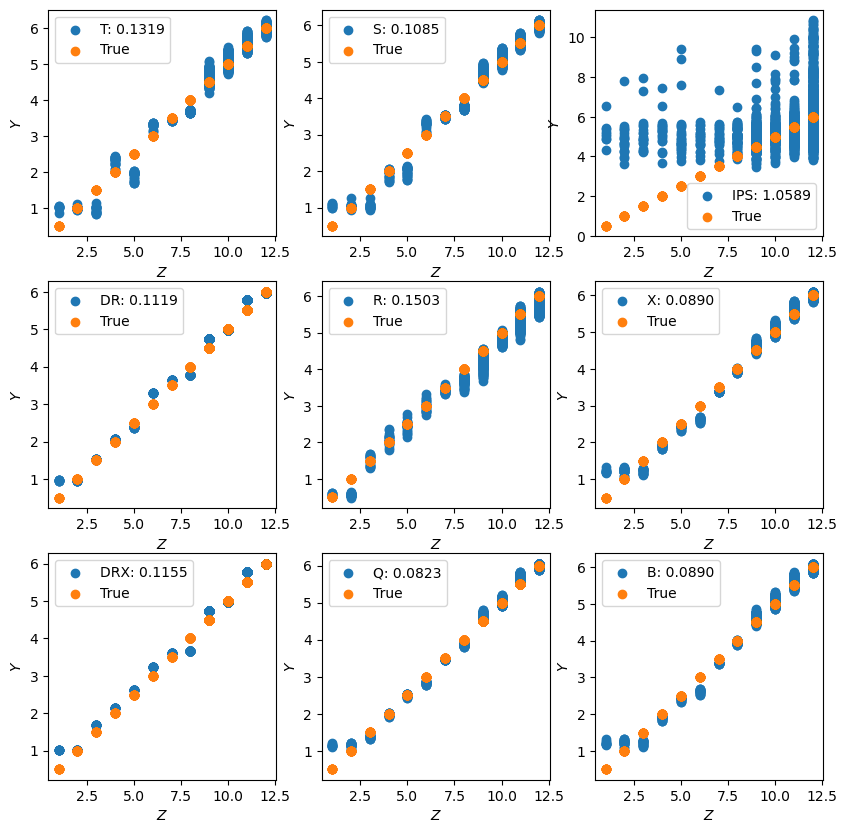

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(3, 3, it + 1)
    plt.scatter(cates['Ztest'][:, 1], cates[name], label=f'{name}: {np.sqrt(mse):.4f}')
    plt.scatter(cates['Ztest'][:, 1], cates['True'],  label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.show()

In [ ]:
results = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(data,
                                                             semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             max_depth=max_depth,
                                                             scale=scale,
                                                             true_f=simple_true_cef,
                                                             train_on_val=True,
                                                             cfit_on_val=True,
                                                             random_state=it)
                                                  for it in range(100))

In [ ]:
mses, _ = results[0]
names = list(mses.keys())
rmses_agg = {}
rmses_all = {}
for name in names:
    mses = [r[0][name] for r in results]
    rmses_all[name] = np.sqrt(np.array(mses))
    rmses_agg[name] = (np.mean(rmses), np.std(rmses), np.std(rmses) / np.sqrt(len(results)))

min_rmse, _, _ = np.min(pd.DataFrame(rmses_agg), axis=1)
min_ind, _, _ = np.argmin(pd.DataFrame(rmses_agg).values, axis=1)
min_name = names[min_ind]
min_rmse_std = rmses_agg[min_name][2]


plt.show()
it = 0
for name, (mean, std, stderr) in rmses_agg.items():
    if mean >= min_rmse + 20*min_rmse_std:
        continue
    plt.violinplot(rmses_all[name], positions=[it], showmeans=True, showmedians=True, showextrema=True)
    plt.scatter(name, mean)
    plt.errorbar(name, mean, yerr=2*stderr)
    it += 1
plt.title(f'DGP {dgp}')
plt.xlabel('Method')
plt.ylabel('RMSE')
plt.xlim([-1, it])
plt.show()